In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import experimentdataanalysis.analysis.dataframe_plotting as dfplot

In [2]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
    

In [3]:
import experimentdataanalysis.data_io.metadataparsing as metadataparsing

def parse_filepath_and_header(filepath, header_string=None,
                              parsing_keyword_lists=None,
                              existing_metadata_dict=None):
    if existing_metadata_dict is None:
        existing_metadata_dict = {}
    metadata_dict = metadataparsing.analyze_scan_filepath(filepath,
                                                          existing_metadata_dict,
                                                          parsing_keyword_lists)
    if header_string is not None:
        metadataparsing.analyze_string_for_dict_pairs(header_string, metadata_dict)
    return metadata_dict

def process_directory_csvs_to_dataframes(parent_dir,
                                         run_criteria='directory',
                                         pandas_read_csv_kwargs={},
                                         parsing_keyword_lists=None,
                                         metadata_processing_fcns=[],
                                         metadata_filter_fcns=[],
                                         metadata_tag_to_column_list=[],
                                         dataframe_processing_fcns=[]):
    """Searches given directory for data files and parses them into
    pandas dataframes using pandas' read_csv function. Performs the
    following processing functions for each csv file found:
    1. Creates a metadata dict using the data_io.metadataparsing
       package and optionally the user-provided parsing_keyword_lists.
    2. Determines a "Run ID" key in the metadata based on the
       user-provided 'run_criteria', by default based on file's directory.
    2. Optionally calls all functions in user-provided
       metadata_processing_fcns list with metadata dict as parameter.
    3. Optionally calls all functions in user-provided
       metadata_filter_fcns list with metadata dict as parameter,
       and aborts processing the file if any function
       returns False.
    4. Creates a pandas dataframe from the contents of the file,
       optionally passing the user-provided pandas_read_csv_kwargs.
    5. Optionally looks for all tuples of form
       ('metadata tag', 'column name') in user-provided
       metadata_tag_to_column_list, and for each creates a column
       with the given name, with each row populated by the the 
       value corresponding to the metadata dict's associated tag.
    6. Finally, optionally calls all functions in user-provided
       dataframe_processing_fcns list with dataframe as parameter.
       Any values returned by function are unused; editing of
       dataframe generally requires use of pandas functions
       with the 'inplace' keyword argument set to True.
    The resulting lists of filenames, dataframes, and
    metadata dicts are returned, omitting rows filtered out
    via metadata_filter_fcns from all three lists.
    """
    # LOAD AND NOMINALLY FILTER DATA:
    unfiltered_filepath_list = []
    for dirpath, dirnames, filenames in os.walk(parent_dir):
        for filename in filenames:
            if filename_key in filename:
                unfiltered_filepath_list.append(os.path.join(dirpath, filename))
    if run_criteria == 'directory':
        last_dir = ''
        run_counter = -1        
    else:
        raise NotImplementedError("currently only supported run " +
                                  "criteria is grouping-by-directory")
    num_headerlines = pandas_read_csv_kwargs['skiprows']
    filtered_file_list_index = 0
    filtered_filepath_list = []
    file_metadata_list = []
    file_dataframes_list = []
    for filepath in unfiltered_filepath_list:
        with open(filepath) as file_lines_iterator:
            try:
                header_lines = [next(file_lines_iterator)
                                for line in range(num_headerlines)]
                file_dataframe = \
                    pd.read_csv(filepath_or_buffer=file_lines_iterator,
                                **pandas_read_csv_kwargs)
            except StopIteration:
                print("Problem encountered in process_directory_csvs_to_dataframes():")
                print("Tried to skip {} header lines, ".format(num_headerlines) +
                      "but file was too short. Skipping file...")
                print("Filepath: {}".format(filepath))
                continue
            # TODO: catch other exceptions for read_csv errors?
        # parse filepath, file header, and determine Run ID
        file_metadata = parse_filepath_and_header(filepath,
                                                  ''.join(header_lines),
                                                  parsing_keyword_lists)
        if run_criteria == 'directory':
            current_dir = filepath.split('\\')[-2]
            if current_dir != last_dir:
                last_dir = current_dir
                run_counter += 1
            file_metadata['Run ID'] = run_counter

        # metadata processing and filtering
        for metadata_processing_fcn in metadata_processing_fcns:
            metadata_processing_fcn(file_metadata)
        if not all([metadata_filter_fcn(file_metadata)
                    for metadata_filter_fcn in metadata_filter_fcns]):
            continue

        # dataframe processing
        file_dataframe['file_index'] = filtered_file_list_index
        for metadata_tag, column_name in metadata_tag_to_column_list:
            if metadata_tag in file_metadata.keys():
                file_dataframe[column_name] = file_metadata[metadata_tag]
        for dataframe_processing_fcn in dataframe_processing_fcns:
            dataframe_processing_fcn(file_dataframe)

        filtered_filepath_list.append(filepath)
        file_dataframes_list.append(file_dataframe)
        file_metadata_list.append(file_metadata)
        filtered_file_list_index += 1
    return filtered_filepath_list, file_dataframes_list, file_metadata_list




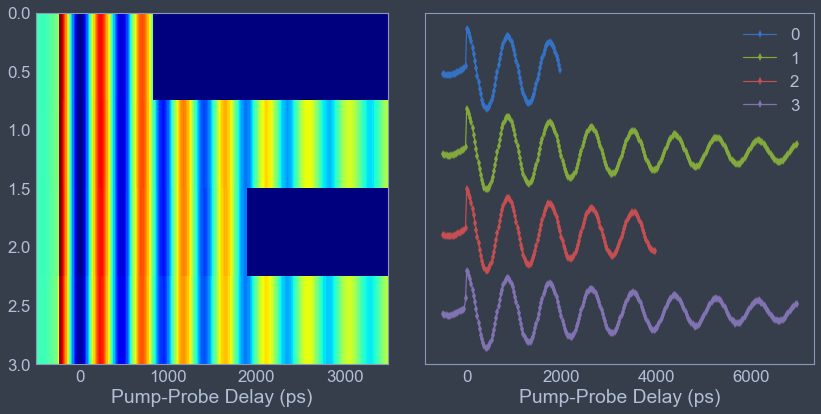

probe_delay   lockin1  lockin2  file_index  \
run_id index_2d index_1d                                               
0      0.0      0           -500.2216  0.000130 -0.02200           0   
                1           -475.2909  0.000122 -0.02742           0   
                2           -450.3601  0.000088 -0.03182           0   
                3           -425.4294  0.000033 -0.03474           0   
                4           -400.2216  0.000050 -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0

In [7]:
import os

# REQUIRED: directory containing 2D scans
# parent_dir = ('C:\\Data\\feb2017_data_part2')
parent_dir = ('C:\\Data\\FitTrialData2\\Delay_Scan')

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = True  # rows end in delimiters
num_headerlines = 0
column_names_row = 1  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
run_criteria = 'directory'

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = [
    (       "CISP", "Experiment Type", "CISP"       ),
    ( "Delay_Scan", "Experiment Type", "Delay_Scan" ),
    ( "Field_Scan", "Experiment Type", "Field_Scan" ),
    ("Mirror_Scan", "Experiment Type", "Mirror_Scan"),
    ( "RMBE1130-K", "Sample ID", "RMBE1130-K"),
    ("[1-10]Horiz", "Sample Orientation", "[1-10]Horiz"),
]
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = []
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [
    ("FIELD", "Date_and_Scan_2D_Index"),
    ("DLAY", "Date_and_Scan_2D_Index"),
    ("STPR", "Date_and_Scan_2D_Index"),
    ("phi-", "Electric Field Angle"),
    ("T", "Magnetic Field (T)"),
    ("K", "Set Temperature (K)"),
    ("nm", "Wavelength (nm)"),
    ("ps", "Delay Time (ps)"),
    ("mV", "Voltage (mV)"),
]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def derive_metadata_from_scan_type_tag(metadata_dict):
    if 'Date_and_Scan_2D_Index' in metadata_dict.keys():
        date_and_index = str(metadata_dict['Date_and_Scan_2D_Index'])
        metadata_dict['Date'] = date_and_index[:6]
        metadata_dict['Scan_2D_Index'] = float(date_and_index[6:]) - 1
        del metadata_dict['Date_and_Scan_2D_Index']
def consolidate_aliases_for_bfield(metadata_dict):
    if 'Magnetic Field (T)' in metadata_dict.keys():
        metadata_dict['Magnetic Field (mT)'] = \
            1000.0 * metadata_dict['Magnetic Field (T)']
metadata_processing_fcns = [derive_metadata_from_scan_type_tag,
                            consolidate_aliases_for_bfield]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
metadata_filter_fcns = [
#     lambda metadata_dict: metadata_dict.get("# repeats", 1) <= 2,
    lambda metadata_dict: "alignment" not in metadata_dict.get("Filepath"),
    lambda metadata_dict: "Scan_2D_Index" in metadata_dict.keys(),
]

# OPTIONAL: metadata tags to be converted to dataframe columns.
# Elements should be of form ('metadata tag', 'column name')
metadata_tag_to_column_list = [
    (             'Run ID', 'run_id'),
    (      'Scan_2D_Index', 'index_2d'),
    ('Magnetic Field (mT)', 'b_external'),
    (    'Wavelength (nm)', 'wavelength'),
]

# OPTIONAL: dataframe processing functions,
# must accept dataframe and modify in-place
def set_dataframe_indices(df):
    df['index_1d'] = df.index  # assumes index = 0,1,2,...  
    df.set_index(['run_id', 'index_2d', 'index_1d'],
                 drop=True, append=False, inplace=True)
def edit_dataframe_colnames(df):
    renaming_dict = {}
    if 'Delay (ps)' in list(df):
        renaming_dict['Delay (ps)'] = 'probe_delay'
    if 'Lock-In 1 (V)' in list(df):
        renaming_dict['Lock-In 1 (V)'] = 'lockin1'
    if 'Lock-In 2 (V)' in list(df):
        renaming_dict['Lock-In 2 (V)'] = 'lockin2'
    df.rename(columns=renaming_dict, inplace=True)
dataframe_processing_fcns = [
    set_dataframe_indices,
    edit_dataframe_colnames,
]

filepath_list, file_dataframes_list, file_metadata_list = \
    process_directory_csvs_to_dataframes(parent_dir, run_criteria,
                                         pandas_read_csv_kwargs,
                                         parsing_keyword_lists,
                                         metadata_processing_fcns,
                                         metadata_filter_fcns,
                                         metadata_tag_to_column_list,
                                         dataframe_processing_fcns)

full_dataframe = pd.concat(file_dataframes_list)
full_dataframe.sort_index(ascending=True, inplace=True)

# plot newly created dataframe and show the first few rows
figure_size = (12, 6)
num_waterfall_plots = 4
data_column = 'lockin2'
x_values_column = 'probe_delay'
y_values_column = None
xlabel = 'Pump-Probe Delay (ps)'
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                x_values_column, y_values_column,
                                fill_value=full_dataframe['lockin2'].min(),
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.show()
full_dataframe.head(5)

In [5]:
# TAKE A LOOK AT ANY SUBFILE
file_index = 0
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].head()

File Last Modified: Tue Jun 13 22:01:31 2017
Magnetic Field (T): 0.2
Filepath: C:\Data\FitTrialData2\Delay_Scan\170606DLAY01 Delay_Scan RMBE1130-K_30K_836nm_[1-10]Horiz_0.2T.dat
Run ID: 0
Date: 170606
Set Temperature (K): 30.0
Sample ID: RMBE1130-K
Magnetic Field (mT): 200.0
Wavelength (nm): 836.0
Sample Orientation: [1-10]Horiz
Scan_2D_Index: 0.0


probe_delay   lockin1  lockin2  file_index  \
run_id index_2d index_1d                                               
0      0.0      0           -500.2216  0.000130 -0.02200           0   
                1           -475.2909  0.000122 -0.02742           0   
                2           -450.3601  0.000088 -0.03182           0   
                3           -425.4294  0.000033 -0.03474           0   
                4           -400.2216  0.000050 -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0